## Import libraries and data

In [1074]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1136]:
my_file = open('Stocks_List.txt','r')
stocks = my_file.read().split('\n')
stock_analysis = ['AAPL', 'PG']
n_stock = len(stock_analysis)
basis = np.eye(len(stock_analysis))
time_frame = '1y'

In [1137]:
tickers = {stock: yf.Ticker(stock) for stock in stocks}

# Use daily return percentages
data = pd.DataFrame({stock: tickers[stock].history(period=time_frame)['Close'].pct_change() for stock in stock_analysis})

## Exact Calculation

### Return
The expected return of each asset will be calculated by

$$E\left[r_i\right]=\mu_i$$

where $\mu_i$ is the mean of the historical data. Thus, the total expected return for a portfolio is given by

$$\sum_{i=1}^n w_i\mu_i=\mathbf{w}^T\mathbf{\mu}.$$

where $\mathbf{\mu}=\left[\mu_1,\ldots,\mu_2\right]^T$ is the vector of the expected returns and $\mathbf{w}=\left[w_1,\ldots,w_2\right]^T$ is the vector of the weights of each stock in the portfolio.


### Risk

The risk is measured as the variance of the returns given by

$$\sigma_i^2=\textrm{Var}\left(r_i\right)=E\left[\left(r_i-\mu_i\right)^2\right]$$

and the covariance between two assets $i$ and $j$ is given by

$$\sigma_{ij}=\textrm{Cov}\left(r_i,r_j\right)=E\left[\left(r_i-\mu_i\right)\left(r_j-\mu_j\right)\right].$$

Using matrix notation, the covariances can be put into a covariance matrix, $K$, such that

$$K=\left[\sigma_{ij}\right].$$

The total variance of the portfolio is going to be

$$\sigma_P^2=E\left[\left(r_P-\mu_P\right)^2\right]=\sum_{i=1}^n\left(\sigma_iw_i\right)^2+2\sum_{i=1}^{n-1}\sum_{j=i+1}^nw_iw_j\sigma_{ij}=\mathbf{w}^TK\mathbf{w}$$

## Risk-Return Problem

If we want an expected return $r_0$, then the problem becomes,

$$
\textrm{minimize } \mathbf{w}^TK\mathbf{w}
$$
such that
$$
\mathbf{w}^T\mathbf{\mu}=r_0\\
w_i\ge0,\forall i\\
\mathbf{w}^T\mathbf{e}=1
$$

where $\mathbf{e}=\left[1,1,\ldots,\right]^T$ is a vector of all ones. The solution becomes

$$\mathbf{w}=K^{-1}\left[\begin{array}{cc}\mathbf{\mu}&\mathbf{e}\end{array}\right]A^{-1}\left[\begin{array}{c} r_0\\1\end{array}\right]$$

where $A$ is given by

$$A=\left[\begin{array}{cc}\mathbf{\mu}^TK^{-1}\mathbf{\mu}&\mathbf{\mu}^TK^{-1}\mathbf{e}\\
\mathbf{\mu}^TK^{-1}\mathbf{e}&\mathbf{e}^TK^{-1}\mathbf{e}\end{array}\right].$$

In [1228]:
mu = np.array([data.mean()]).T
coVa = np.array(data.cov())
returns = np.linspace(min(mu),max(mu),num=100)
one = np.ones((len(mu),1))

coVainv = np.linalg.inv(coVa)

a = np.dot(mu.T,np.dot(coVainv,mu))[0][0]
b = np.dot(mu.T,np.dot(coVainv,one))[0][0]
c = np.dot(one.T,np.dot(coVainv,one))[0][0]

Am = [[a,b],[b,c]]

Ainv = np.linalg.inv(Am)

def get_weights(return0):
    rhs = np.dot(Ainv,np.array([[return0],[1]]))
    lhs = np.dot(coVainv,np.concatenate((mu,one),axis=1))
    return np.dot(lhs,rhs)

def get_ret_var(return0):
    weights = get_weights(return0)
    return [np.dot(weights.T,np.dot(coVa,weights))[0][0],np.dot(weights.T,mu)[0][0]]

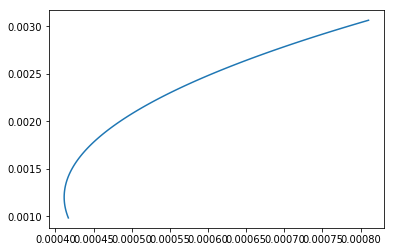

In [1229]:
frontier = np.array([get_ret_var(return0[0]) for return0 in returns])
x,y = frontier.T
plt.plot(x,y)

## Using Evolutionary Algorithms

In [1238]:
def returns_variance(w):
    weights = np.array([w]).T
    if feasible(w):
        return np.dot(weights.T,np.dot(coVa,weights))[0][0], np.dot(weights.T,mu)[0][0]
    else:
        return 10000.0, -10000.0

def feasible(w):
    for i in range(len(w)):
        if w[i] < 0 or w[i] > 1.0:
            return False
    if sum(w) > 1.0:
        return False
    return True

def uniform_region():
    return np.diff(np.array([0]+sorted([random.random() for i in range(n_stock-1)])+[1]))

def cxLine(ind1,ind2,p=1/3):
    ind1[:], ind2[:] = p*ind1+(1-p)*ind2, (1-p)*ind1+p*ind2
    return ind1, ind2

def mutShift(ind1,indpb=1.0/(n_stock-1)):
    interval = np.cumsum(ind1)[:-1]
    for i in range(n_stock-1):
        if random.random() < indpb:
            interval[i] = random.random()
    ind1[:] = np.diff(np.array([0]+sorted(interval)+[1]))
    return ind1,

def validate(func):
    def wrapper(*args, **kargs):
        inds = func(*args,**kargs)
        for ind in inds:
            ind[:] = ind/sum(ind)
        return inds
    return wrapper

In [1288]:
import random, copy
import multiprocessing
from deap import tools, base, creator, algorithms

creator.create("FitnessMin", base.Fitness, weights=(-1.0,1.0))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

IND_SIZE = n_stock

toolbox = base.Toolbox()
#history = tools.History()
stats = tools.Statistics()
stats.register("pop", copy.deepcopy)

toolbox.register("attribute", random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attribute, n=IND_SIZE)
#toolbox.register("attribute", uniform_region)
#toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attribute)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=0, up=1, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=0, up=1, eta=20.0, indpb=1.0/IND_SIZE)
toolbox.decorate("mate", validate)
toolbox.decorate("mutate", validate)
#toolbox.decorate("mate", history.decorator)
#toolbox.decorate("mutate", history.decorator)

toolbox.register("select", tools.selNSGA2)
toolbox.register("evaluate", returns_variance)

pool = multiprocessing.Pool(8)
toolbox.register("map", pool.map)

In [1287]:
pop = toolbox.population(n=500)
#history.update(pop)
CXPB, MUTPB, NGEN = 0.8, 0.2, 10

pop, logbook = algorithms.eaSimple(pop,toolbox,cxpb=CXPB,mutpb=MUTPB,ngen=NGEN,stats=stats,verbose=False)

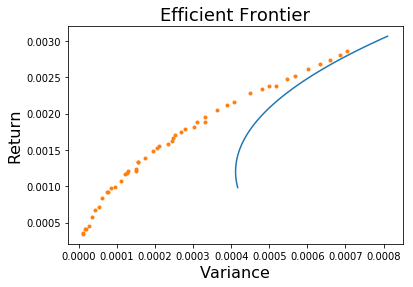

In [1282]:
non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
fitnesses = toolbox.map(toolbox.evaluate,non_dom)
x1, y1 = np.array(fitnesses).T
plt.title('Efficient Frontier',fontsize=18)
plt.xlabel('Variance',fontsize=16)
plt.ylabel('Return',fontsize=16)
plt.plot(x,y)
plt.plot(x1,y1,'.')

Text(0, 0.5, 'PG')

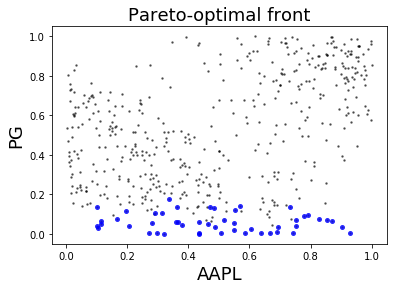

In [1283]:
x2 = [ind[0] for ind in pop]
y2 = [ind[1] for ind in pop]

x3 = [ind[0] for ind in non_dom]
y3 = [ind[1] for ind in non_dom]
plt.plot(x2, y2, 'k.', ms=3, alpha=0.5)
plt.plot(x3, y3, 'bo', alpha=0.74, ms=4)
plt.title('Pareto-optimal front',fontsize=18)
plt.xlabel('AAPL',fontsize=18)
plt.ylabel('PG',fontsize=18)

MovieWriter ffmpeg unavailable. Trying to use pillow instead.


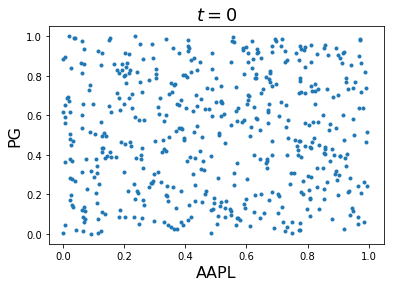

In [1284]:
from matplotlib import animation

def update(i):
    'Updates all plots to match frame _i_ of the animation.'
    new_pop = logbook.select('pop')[i]
    scat.set_xdata([ind[0] for ind in new_pop])
    scat.set_ydata([ind[1] for ind in new_pop])
    ax.set_title('$t=$' + str(i),fontsize=18)
    return []

fig, ax = plt.subplots()

x2 = [ind[0] for ind in pop]
y2 = [ind[1] for ind in pop]
scat, = ax.plot(x2, y2, '.')
ax.set_xlabel('AAPL',fontsize=16)
ax.set_ylabel('PG',fontsize=16)

anim = animation.FuncAnimation(fig, update, frames=np.arange(0,NGEN+1), interval=200)
anim.save('evolution.gif',dpi=80)

MovieWriter ffmpeg unavailable. Trying to use pillow instead.


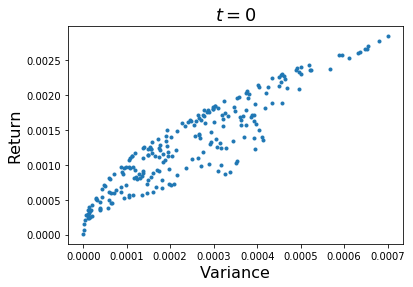

In [1285]:
def updatefit(i):
    'Updates all plots to match frame _i_ of the animation.'
    new_pop = logbook.select('pop')[i]
    valid = [ind for ind in new_pop if feasible(ind)]
    fitnesses = toolbox.map(toolbox.evaluate,valid)
    x2, y2 = np.array(fitnesses).T
    scat.set_xdata(x2)
    scat.set_ydata(y2)
    ax.set_title('$t=$' + str(i),fontsize=18)
    return []

fig, ax = plt.subplots()
new_pop = logbook.select('pop')[0]
valid = [ind for ind in new_pop if feasible(ind)]
fitnesses = toolbox.map(toolbox.evaluate,valid)
x2, y2 = np.array(fitnesses).T
scat, = ax.plot(x2, y2, '.')
ax.set_xlabel('Variance',fontsize=16)
ax.set_ylabel('Return',fontsize=16)

anim = animation.FuncAnimation(fig, updatefit, frames=np.arange(0,NGEN+1), interval=200)
anim.save('evolution_fit.gif',dpi=80)